In [2]:
import time
import numpy as np
import torch 
import cv2
import os
import uuid 
import path
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil
from mtcnn import MTCNN
from tensorflow.keras.layers import Layer
import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
import scipy.misc
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
#setting up the Path 
POS_PATH='/Users/siddharth/Siamesedata/positive'
NEG_PATH='/Users/siddharth/Siamesedata/negative'
ANC_PATH='/Users/siddharth/Siamesedata/anchor'

In [5]:
#seting up directories 
os.makedirs(POS_PATH,exist_ok= True)
os.makedirs(NEG_PATH,exist_ok= True)
os.makedirs(ANC_PATH,exist_ok= True)

In [6]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(6000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(6000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(6000)

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'/Users/siddharth/Siamesedata/anchor/Eliott_Spitzer_0001.jpg',
 b'/Users/siddharth/Siamesedata/positive/Miranda_Otto_0001.jpg',
 1.0)

In [9]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)


# Data Pipeline 

In [10]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


# ResNet50 (generates 512 embedding of images) 

In [11]:

from typing import Tuple
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    ZeroPadding2D,
    Add,
    AveragePooling2D,
    Flatten,
    Dense,
)
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model


def identity_block(X, level, block, filters):
    """
    Implementation of the identity block as defined in the ResNet model.

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    level -- level/layer of the block (used for naming)
    block -- block identifier (used for naming)
    filters -- python list of integers, defining the number of filters in the CONV layers

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve filters
    f1, f2, f3 = filters

    # Define names for the layers using the provided level and block numbers
    conv_name = 'res' + str(level) + '_' + str(block) + '_{}_{}'

    # Save the input value to be used in the skip connection
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(1, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(1, 'bn'))(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(2, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(2, 'bn'))(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(3, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(3, 'bn'))(X)

    # Add shortcut value to main path and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def convolutional_block(X, level, block, filters, s=2):
    """
    Implementation of the convolutional block as defined in the ResNet model.

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    level -- level/layer of the block (used for naming)
    block -- block identifier (used for naming)
    filters -- python list of integers, defining the number of filters in the CONV layers
    s -- stride for the first convolutional layer in the block

    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """

    # Retrieve filters
    f1, f2, f3 = filters

    # Define names for the layers using the provided level and block numbers
    conv_name = 'res' + str(level) + '_' + str(block) + '_{}_{}'

    # Save the input value to be used in the skip connection
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(s, s), padding='valid',
               name=conv_name.format(1, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(1, 'bn'))(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(2, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(2, 'bn'))(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(3, 'conv'), kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(3, 'bn'))(X)

    # Shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=(s, s), padding='valid',
                        name=conv_name.format('shortcut', 'conv'), kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format('shortcut', 'bn'))(X_shortcut)

    # Add shortcut value to main path and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


def ResNet50(input_size: Tuple[int, int, int], embedding_size: int) -> Model:
    """
    Implementation of the ResNet50 architecture.

    Arguments:
    input_size -- shape of the input images (height, width, channels)
    embedding_size -- size of the embedding vector

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input placeholder as a tensor with shape input_size
    X_input = Input(input_size)

    # Zero-padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=1)
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    # Stage 3
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=2)
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    # Stage 4
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=2)
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=2)
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Average pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # Flatten the output
    X = Flatten()(X)

    # Fully connected layer
    X = Dense(embedding_size, activation='linear', name='fc' + str(embedding_size),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model instance
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


# Create ResNet50 model for input images of size 100x100 and embedding size of 128
input_size = (100, 100, 3)
embedding_size = 512
model = ResNet50(input_size, embedding_size)


# Siamese Model 

In [12]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [13]:
l1 = L1Dist()

In [14]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Get embeddings using your ResNet model
    inp_embedding = model(input_image)
    val_embedding = model(validation_image)

    # Siamese L1 Distance class
    class L1Dist(Layer):
        def __init__(self, **kwargs):
            super().__init__()

        def call(self, input_embedding, validation_embedding):
            return tf.math.abs(input_embedding - validation_embedding)

    l1 = L1Dist()
    distances = l1(inp_embedding, val_embedding)

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')



In [15]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 ResNet50 (Functional)       (None, 512)                  2463680   ['input_img[0][0]',           
                                                          0          'validation_img[0][0]']      
                                                                                     

In [16]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [17]:
checkpoint_dir = '/Users/siddharth/Siamesedata/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)


In [18]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [19]:
tf.losses.BinaryCrossentropy??

# Training the model 

In [20]:
class CustomStopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        
        # Stop training if the loss is below or equal to 0.002, FAR is less than 0.1, and FRR is less than 2.5
        if logs.get('loss') <= 0.002 and logs.get('FAR') < 0.1 and logs.get('FRR') < 2.5:
            print("\nReached the desired loss, FAR, and FRR. Stopping training.")
            self.model.stop_training = True


In [21]:
def calculate_far_frr(y_true, y_pred):
    # Convert the predictions to binary (0 or 1) based on a threshold of 0.5
    y_pred_binary = tf.where(y_pred >= 0.5, 1.0, 0.0)

    # Calculate the confusion matrix
    tp = tf.reduce_sum(tf.multiply(y_true, y_pred_binary))
    tn = tf.reduce_sum(tf.multiply(1 - y_true, 1 - y_pred_binary))
    fp = tf.reduce_sum(tf.multiply(1 - y_true, y_pred_binary))
    fn = tf.reduce_sum(tf.multiply(y_true, 1 - y_pred_binary))

    # Calculate FAR and FRR
    far = fp / (fp + tn)
    frr = fn / (fn + tp)

    return far, frr

In [22]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [23]:
# Function to load the last checkpointed model and epoch number (if available)
def load_checkpoint(siamese_model, checkpoint_dir):
    checkpoint = tf.train.Checkpoint(model=siamese_model)
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        # Extract the epoch number from the checkpoint name
        start_epoch = int(latest_checkpoint.split('-')[-1])
    else:
        start_epoch = 0
    return start_epoch


 Epoch 1/100
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 0s 166ms/step


525/525 [==============================] - 491s 921ms/step
Loss: 0.7627917 Recall: 0.45723763 Precision: 0.5
FAR: 0.0 FRR: 0.7


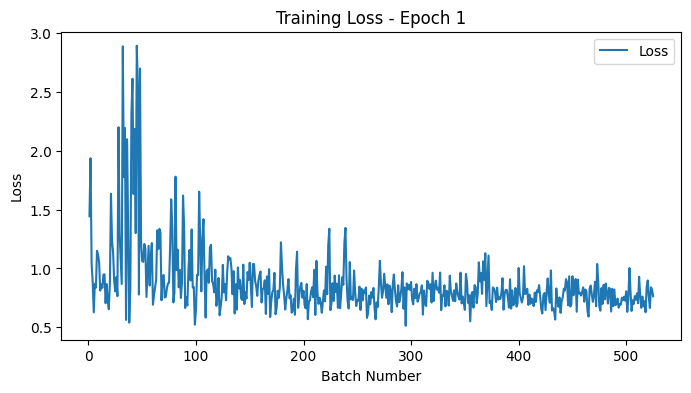


 Epoch 2/100
1/1 [==============================] - 0s 163ms/step


525/525 [==============================] - 498s 948ms/step
Loss: 0.73472345 Recall: 0.51649654 Precision: 0.52522326
FAR: 0.33333334 FRR: 0.42857143


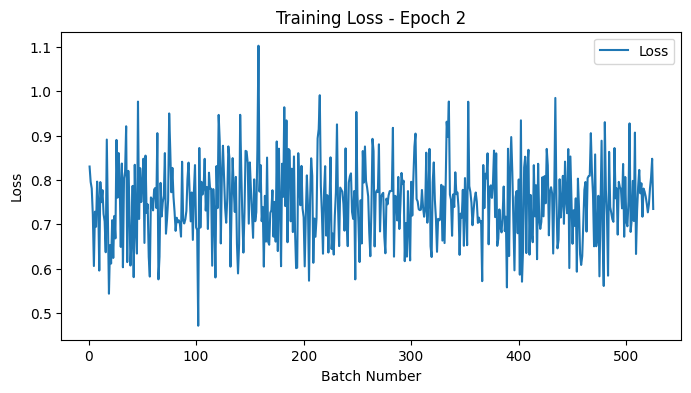


 Epoch 3/100
1/1 [==============================] - 0s 161ms/step


525/525 [==============================] - 460s 876ms/step
Loss: 0.68549204 Recall: 0.5144962 Precision: 0.52345264
FAR: 0.42857143 FRR: 0.6666667


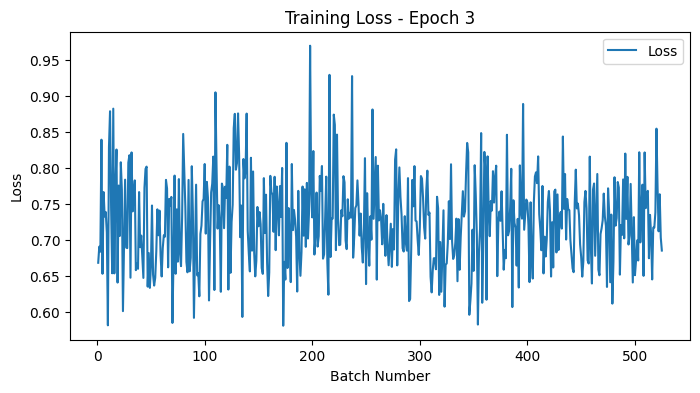


 Epoch 4/100
1/1 [==============================] - 0s 162ms/step


525/525 [==============================] - 456s 869ms/step
Loss: 0.7183923 Recall: 0.5317892 Precision: 0.54086536
FAR: 0.5714286 FRR: 0.44444445


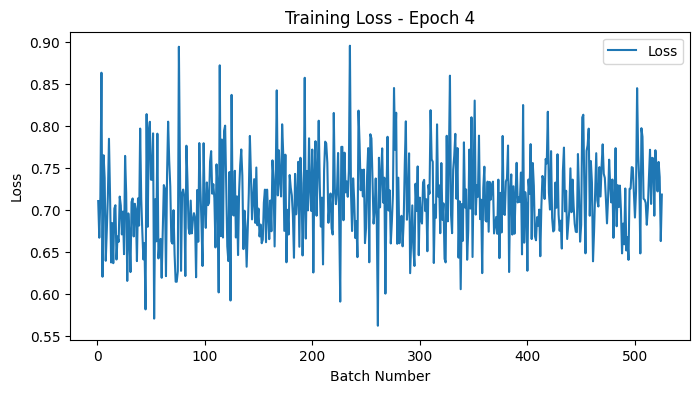


 Epoch 5/100
1/1 [==============================] - 0s 161ms/step


525/525 [==============================] - 486s 925ms/step
Loss: 0.6810882 Recall: 0.5437634 Precision: 0.55125725
FAR: 0.25 FRR: 0.375


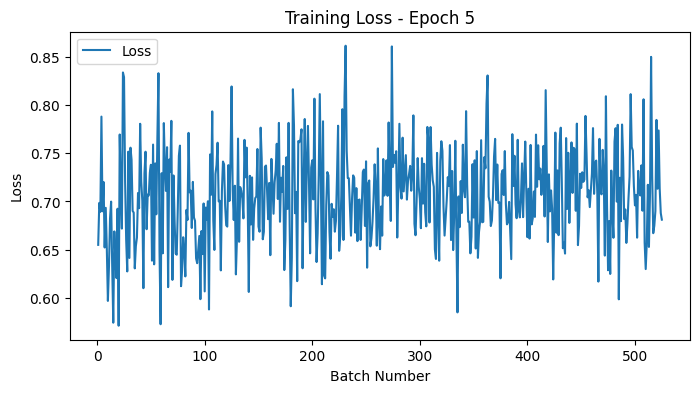


 Epoch 6/100
1/1 [==============================] - 0s 162ms/step


525/525 [==============================] - 467s 889ms/step
Loss: 0.7378638 Recall: 0.5860541 Precision: 0.5600624
FAR: 0.2 FRR: 0.6363636


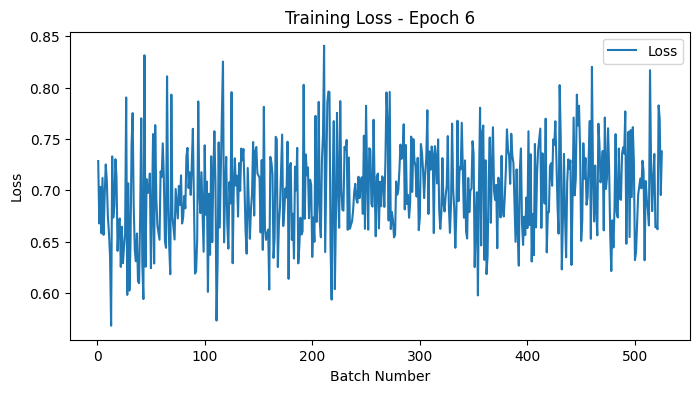


 Epoch 7/100
151/525 [=======>......................] - ETA: 5:32

KeyboardInterrupt: 

In [25]:
def train(data, EPOCHS):
    # Create the custom callback
    custom_stop_callback = CustomStopCallback()
    custom_stop_callback.model = siamese_model  # Set the model attribute

    # Load the last checkpointed model and epoch number (if available)
    start_epoch = load_checkpoint(siamese_model, checkpoint_dir)
    EPOCHS += start_epoch  # Update the total number of epochs

    # Restoring optimizer state is optional but can be done to continue with the same learning rate
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    # Loop through epochs starting from the next epoch after loading the checkpoint
    for epoch in range(start_epoch + 1, EPOCHS + 1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()

        # Lists to store loss values and FAR/FRR values for plotting
        loss_values = []

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx + 1)

            # Append loss value to list
            loss_values.append(loss.numpy())

        # Calculate and print FAR and FRR
        y_true = tf.squeeze(batch[2])
        y_pred = tf.squeeze(yhat)
        far, frr = calculate_far_frr(y_true, y_pred)

        print('Loss:', loss.numpy(), 'Recall:', r.result().numpy(), 'Precision:', p.result().numpy())
        print('FAR:', far.numpy(), 'FRR:', frr.numpy())

        # Plot the loss graph after each epoch with smaller dimensions
        plt.figure(figsize=(8, 4))
        plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss')
        plt.xlabel('Batch Number')
        plt.ylabel('Loss')
        plt.title(f'Training Loss - Epoch {epoch}')
        plt.legend()
        plt.show()

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Check if the custom stop condition is met
        if custom_stop_callback.model.stop_training:
            break

EPOCHS = 100
train(train_data, EPOCHS)


# Saving the model 

In [24]:
# Save weights
siamese_model.save('siamesemodelv2.h5')


/Users/siddharth/facerecognition/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [26]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [27]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

1/1 [==============================] - 1s 806ms/step


[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [28]:
y_true

array([0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

In [29]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [30]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.46666667

In [31]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 194ms/step


1/1 [==============================] - 0s 164ms/step
0.9130932 0.48496813


In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Prediction 

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Ask for the folder name in the verification_images folder from the user
    folder_name = input("Enter the folder name in verification_images: ")

    # Build results array
    results = []
    folder_path = os.path.join('application_data', 'verification_images', folder_name)
    if not os.path.exists(folder_path):
        print("Folder not found.")
        return results, False  # Return empty results and False for verification
    
    for image in os.listdir(folder_path):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join(folder_path, image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(folder_path)) 
    verified = verification > verification_threshold
    
    return results, verified


In [ ]:
import cv2
from mtcnn import MTCNN

cap = cv2.VideoCapture(0)
detector = MTCNN()
capture_image = None

while cap.isOpened():
    ret, frame = cap.read()

    # Display the frame
    cv2.imshow('Verification', frame)
    
    # Capture the image on 'V' key press
    if cv2.waitKey(10) & 0xFF == ord('v'):
        capture_image = frame
        break

if capture_image is not None:
    # Detect face using MTCNN on the captured image
    result = detector.detect_faces(capture_image)

    if len(result) > 0:
        # Get the bounding box coordinates of the face
        x, y, w, h = result[0]['box']

        # Crop the face region from the captured image
        face_image = capture_image[y:y+h, x:x+w]

        # Resize the face image to 100x100
        face_image = cv2.resize(face_image, (100, 100))

        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), face_image)

        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

cap.release()
cv2.destroyAllWindows()


# Input First image for recognition 

In [ ]:
# Initialize the webcam and MTCNN face detector
cap = cv2.VideoCapture(0)
detector = MTCNN()

# Define the verification_images folder path
verification_folder = '/Users/siddharth/Siamesedata/application_data/verification_images'

# Check if the verification_images folder exists, and create it if it doesn't
if not os.path.exists(verification_folder):
    os.makedirs(verification_folder)

while cap.isOpened():
    ret, frame = cap.read()

    # Display the frame
    cv2.imshow('Capture', frame)

    # Check for key press events
    key = cv2.waitKey(1)

    # Start capturing the image on 'V' key press
    if key == ord('v'):
        # Ask for the user's name
        user_name = input("Enter your name: ")

        # Create a folder for the user if it doesn't exist
        user_folder = os.path.join(verification_folder, user_name)
        if not os.path.exists(user_folder):
            os.makedirs(user_folder)

        # Set capture_image to True to initiate image capture
        capture_image = True

    # Capture the image when 'capture_image' is True
    if capture_image:
        # Detect faces using MTCNN on the captured frame
        results = detector.detect_faces(frame)

        if len(results) > 0:
            # Get the bounding box coordinates of the first detected face
            x, y, w, h = results[0]['box']

            # Crop the face region from the frame
            face_image = frame[y:y+h, x:x+w]

            # Resize the face image to 100x100 pixels
            face_image = cv2.resize(face_image, (100, 100))

            # Generate a unique filename using UUID for the saved image
            image_name = str(uuid.uuid4()) + '.jpg'

            # Save the preprocessed face image to the user's folder
            image_path = os.path.join(user_folder, image_name)
            cv2.imwrite(image_path, face_image)

            print('Image saved:', image_name)

            # Reset capture_image to False for the next capture
            capture_image = False

    # Exit the loop on 'Q' key press
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:

# Define the verification_images folder path
verification_folder = '/Users/siddharth/Siamesedata/application_data/verification_images'

# Check if the verification_images folder exists
if os.path.exists(verification_folder):
    # Get a list of all folders in the verification_images folder
    folders = os.listdir(verification_folder)

    # Iterate through each folder in the verification_images folder
    for folder in folders:
        folder_path = os.path.join(verification_folder, folder)

        # Check if the path is a folder
        if os.path.isdir(folder_path):
            # Get a list of all files in the folder
            files = os.listdir(folder_path)

            # Iterate through each file in the folder
            for file in files:
                # Check if the file is not a JPG file
                if not file.lower().endswith('.jpg'):
                    # Construct the file path
                    file_path = os.path.join(folder_path, file)

                    # Delete the file
                    os.remove(file_path)

                    print('Deleted file:', file_path)
else:
    print('verification_images folder does not exist.')
